In [65]:
import torch
import sys
import os
import pandas as pd
import numpy as np
import argparse
import yaml

sys.path.append(os.path.join("..", ".."))
from mmd.mmd import MMD_with_sample
from scipy.signal import resample
from dataloaders.dataloader_HARVAR_har import HARVARUtils
from dataloaders.dataloader_HARVAR_har import HARVAR_CV
from dataloaders.dataloader_REALDISP_har import REALDISPUtils
from dataloaders.dataloader_REALDISP_har import REALDISP_CV

from dataloaders.utils import Normalizer
from configs.config_consts import REALDISP_CV, HARVAR_CV

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

load_only_walking = True

In [66]:
def normalization(train_vali, test=None):
    train_vali_sensors = train_vali.iloc[:, 1:-1]
    normalizer = Normalizer('standardization')
    normalizer.fit(train_vali_sensors)
    train_vali_sensors = normalizer.normalize(train_vali_sensors)
    train_vali_sensors = pd.concat([train_vali.iloc[:, 0], train_vali_sensors, train_vali.iloc[:, -1]], axis=1)
    if test is None:
        return train_vali_sensors
    else:
        test_sensors = test.iloc[:, 1:-1]
        test_sensors = normalizer.normalize(test_sensors)
        test_sensors = pd.concat([test.iloc[:, 0], test_sensors, test.iloc[:, -1]], axis=1)
        return train_vali_sensors, test_sensors

In [67]:
#filter the data with a bandpass filter, 0.5Hz to 20Hz, frequency is 400Hz
from scipy import signal
from scipy.signal import butter, freqz, filtfilt
# Import the required packages
import numpy as np
from scipy.fft import fft, rfft
from scipy.fft import fftfreq, rfftfreq
import matplotlib.pyplot as plt
%matplotlib inline

def lowpass_filter(data, low_cut_off=1, fs=400):
    b, a = butter(4, low_cut_off, fs=fs, btype='lowpass', analog=False)
    y = filtfilt(b, a, data)
    return b, a, y

def bandpass_filter(data, low_cut_off, high_cut_off, fs=400):
    low = low_cut_off / fs
    high = high_cut_off / fs
    order = 2
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return b,a,y

In [68]:
def resample_data(data_x, orig_sampling_rate, new_sampling_rate):
    data_len_orig = data_x.shape[0]
    data_len_new = int(data_len_orig * new_sampling_rate / orig_sampling_rate)
    # resample the data
    data_x = resample(data_x, data_len_new)

    return data_x


def run(dataset, device1, device2):
    if os.path.exists(os.path.join('..', '..', 'data', 'mmd', 'mmd_results_' + device1 + '_' + device2 + '.csv')):
        print('mmd results already exist')
        return

    if dataset == 'harvar':
        if device1.find("maxim") != -1:
            data_name = 'harvar_maxim'
        elif device1.find("empatica") != -1:
            data_name = 'harvar_empat'
        elif device1.find("bluesense") != -1:
            data_name = 'harvar_bluesense'

        if device2.find("maxim") != -1:
            test_data_name = 'harvar_maxim'
        elif device2.find("empatica") != -1:
            test_data_name = 'harvar_empat'
        elif device2.find("bluesense") != -1:
            test_data_name = 'harvar_bluesense'

        data_utils = HARVARUtils()
        # harvar
        # iterating through 8 cv
        full_1_x, full_1_y = data_utils.load_all_the_data_harvar(device1, HARVAR_CV, load_only_walking)
        # normalization
        full_1_x = normalization(full_1_x)
        full_2_x, full_2_y = data_utils.load_all_the_data_harvar(device2, HARVAR_CV, load_only_walking)
        # normalization
        full_2_x = normalization(full_2_x)


        if data_name == 'harvar_maxim':
            train_sampling_rate = 25
        if data_name == 'harvar_empat':
            train_sampling_rate = 64
        if data_name == 'harvar_bluesense':
            train_sampling_rate = 100

        if test_data_name == 'harvar_maxim':
            test_sampling_rate = 25
        if test_data_name == 'harvar_empat':
            test_sampling_rate = 64
        if test_data_name == 'harvar_bluesense':
            test_sampling_rate = 100

        participants = HARVAR_CV

    else:
        data_utils = REALDISPUtils()
        root_path = os.path.join('..', '..', 'data', 'realdisp')
        # realdisp
        # iterating through 34 cv
        full_1_x, full_1_y = data_utils.load_all_the_data_realdisp(root_path, device1, REALDISP_CV)
        # normalization
        full_1_x = normalization(full_1_x)
        full_2_x, full_2_y = data_utils.load_all_the_data_realdisp(root_path, device2, REALDISP_CV)
        # normalization
        full_2_x = normalization(full_2_x)
        participants = REALDISP_CV

    # bandwidth ranges
    bandwidth_range = [0.2, 0.5, 0.9, 1.3, 1.5, 1.6]

    # create a dataframe to store the mean mmd results on 3 axis
    mean_mmd = pd.DataFrame(columns=['CV', 'activity', 'mmd', 'std_div'])

    full_1_x = pd.concat([full_1_x, full_1_y], axis=1)
    full_2_x = pd.concat([full_2_x, full_2_y], axis=1)

    # activities are the unique values in the full_1_y df
    activities = full_1_y.unique()

    for i in participants:
        for j in activities:
            # filter out the activity in focus
            full_1_x_activity = full_1_x[full_1_x['activity_id'] == j]
            full_2_x_activity = full_2_x[full_2_x['activity_id'] == j]
            print('Starting cv', i)
            train = full_1_x_activity[full_1_x_activity['sub_id'] != i]
            test = full_2_x_activity[full_2_x_activity['sub_id'] == i]

            # if either of the test and train is empty, skip the cv. empty due to data missing.
            if train.shape[0] == 0 or test.shape[0] == 0:
                print('Skipping cv', i)
                continue

            # drop the activity column
            train = train.drop(columns=['activity_id'])
            test = test.drop(columns=['activity_id'])

            # get only the 'Acc_X', 'Acc_Y', 'Acc_Z' columns as numpy matrix
            train = train.iloc[:, 1:-1].to_numpy()
            test = test.iloc[:, 1:-1].to_numpy()

            if data_name != test_data_name:
                # resample the data
                test = resample_data(test, test_sampling_rate, train_sampling_rate)

            # get mmd distance for Acc_X, Acc_Y, Acc_Z
            mmd, mmd_std_div = MMD_with_sample(train, test, 100, 50000, 'multiscale', bandwidth_range)

            # mean_mmd_y, std_div_y = MMD_with_sample(train[:, 1], test[:, 1], 100, 50000, 'multiscale', bandwidth_range)
            # mean_mmd_z, std_div_z = MMD_with_sample(train[:, 2], test[:, 2], 100, 50000, 'multiscale', bandwidth_range)
            # store the results in the dataframe
            mean_mmd = pd.concat(
                [mean_mmd,
                 pd.DataFrame({'CV': i, 'mmd': mmd, 'std_div_mmd': mmd_std_div, 'activity': j},
                              index=[0])],
                ignore_index=True)
    # save the results in a csv file
    if not os.path.exists(os.path.join('..', '..', 'data', 'mmd')):
        os.makedirs(os.path.join('..', '..', 'data', 'mmd'))
    mean_mmd.to_csv(os.path.join('..', '..', 'data', 'mmd', 'mmd_results_' + device1 + '_' + device2 + '.csv'),
                    index=False)


In [69]:
dataset = 'harvar'
device1 = 'empatica-left'
device2 = 'empatica-right'

 ----------------------- load all the data -------------------


D:\Concordia\PERCOM_Variability_Model_Research\dataloaders\dataloader_HARVAR_har.py:169: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_x = pd.concat([data_x, activity_data])
D:\Concordia\PERCOM_Variability_Model_Research\dataloaders\dataloader_HARVAR_har.py:170: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_y = pd.concat(


 ----------------------- load all the data -------------------


D:\Concordia\PERCOM_Variability_Model_Research\dataloaders\dataloader_HARVAR_har.py:169: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_x = pd.concat([data_x, activity_data])
D:\Concordia\PERCOM_Variability_Model_Research\dataloaders\dataloader_HARVAR_har.py:170: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_y = pd.concat(


Starting cv 1


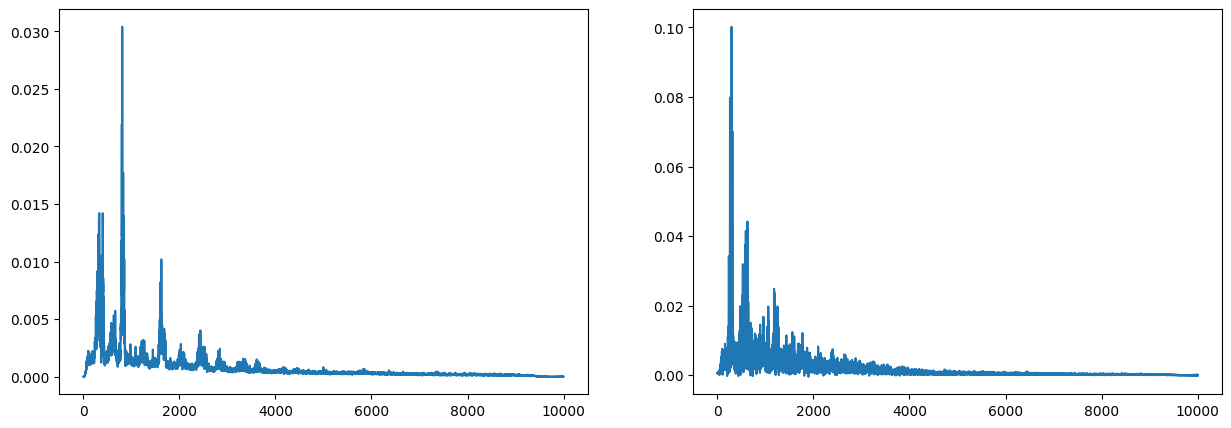

Starting cv 1


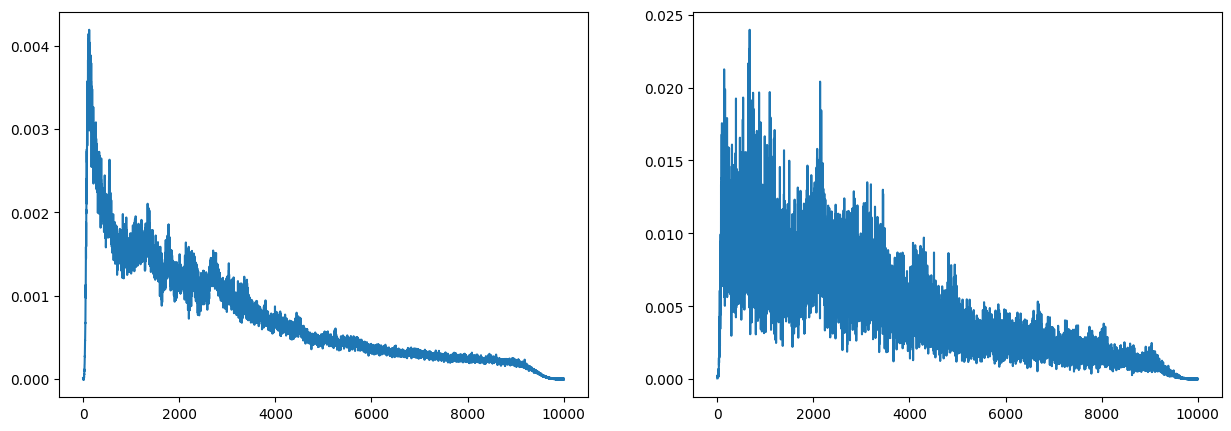

Starting cv 2


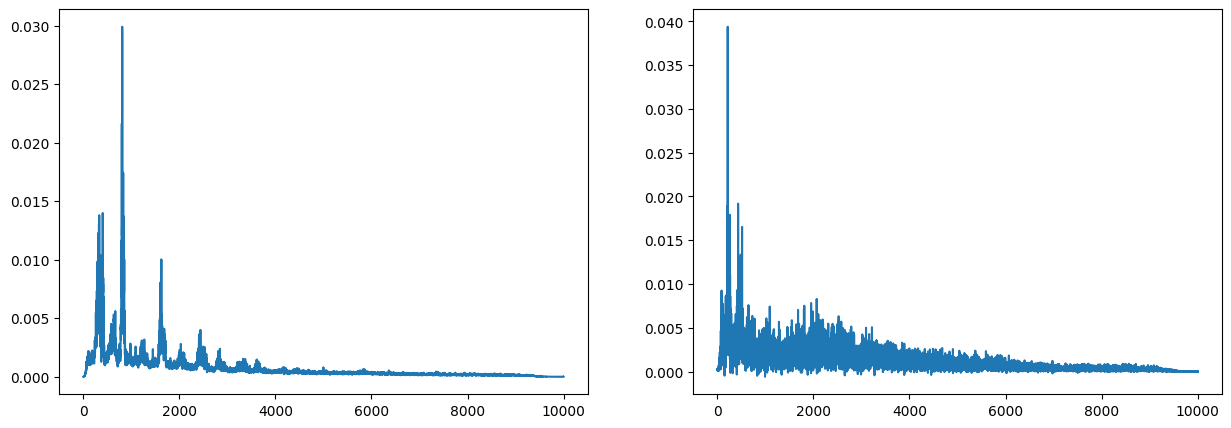

Starting cv 2


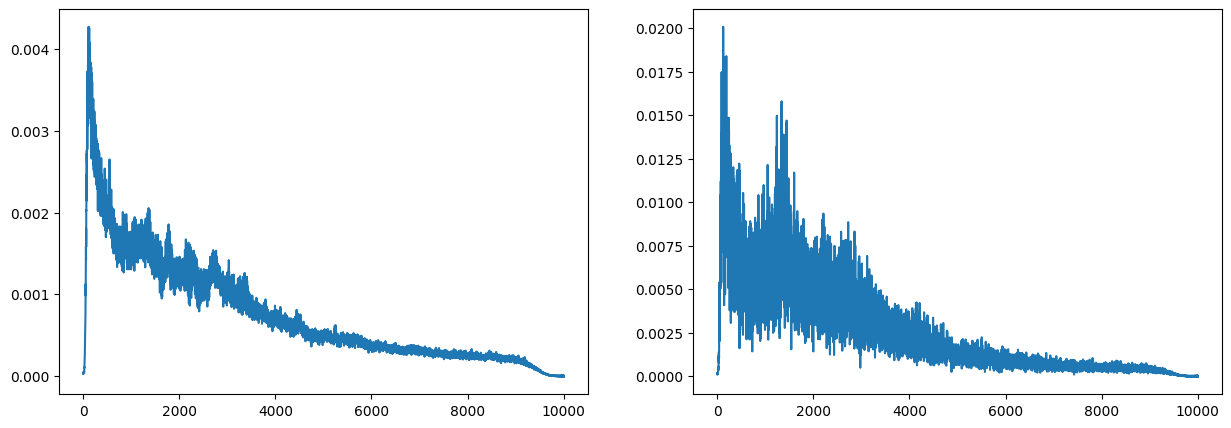

Starting cv 3


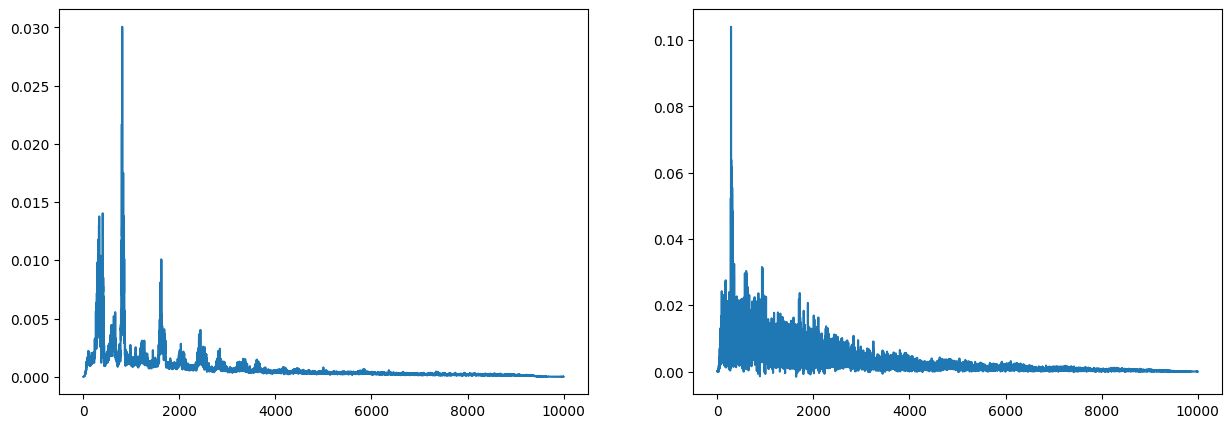

Starting cv 3


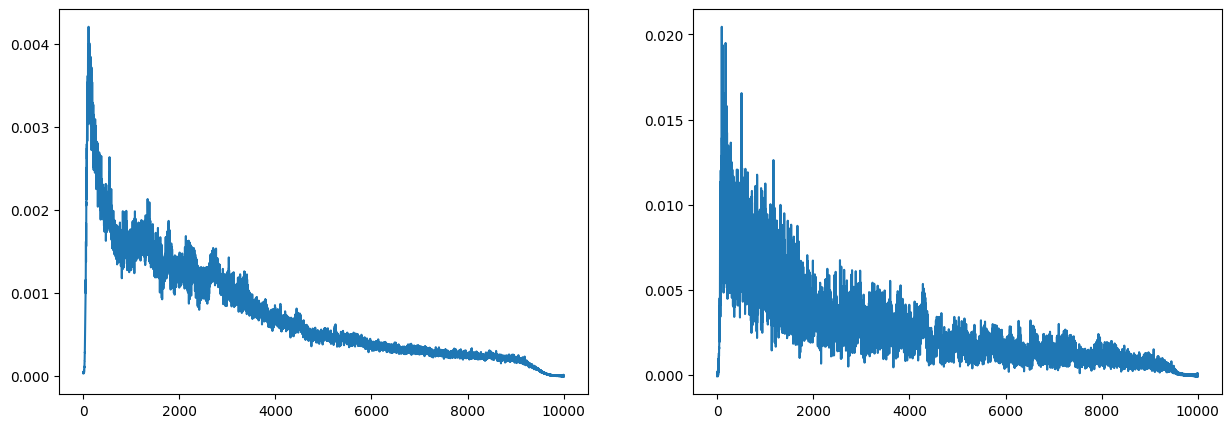

Starting cv 4


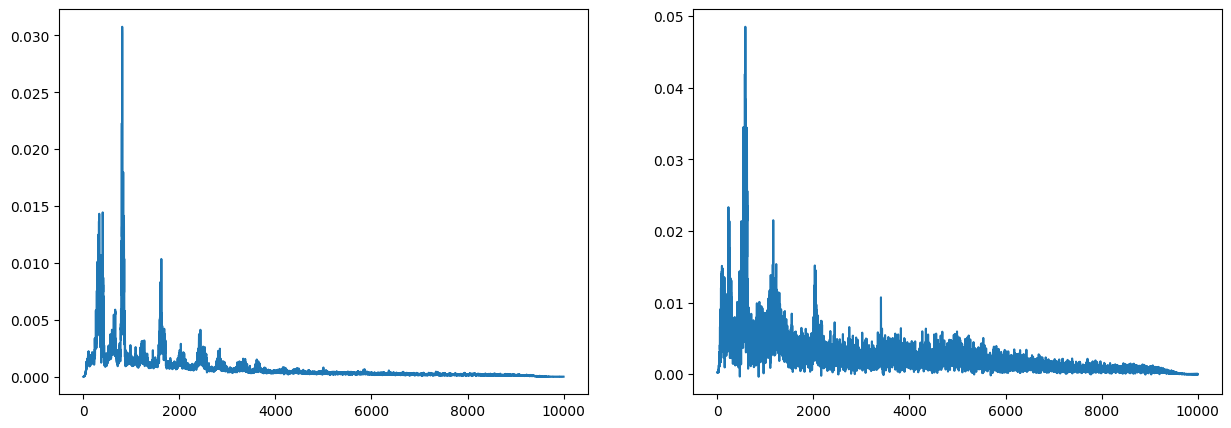

Starting cv 4


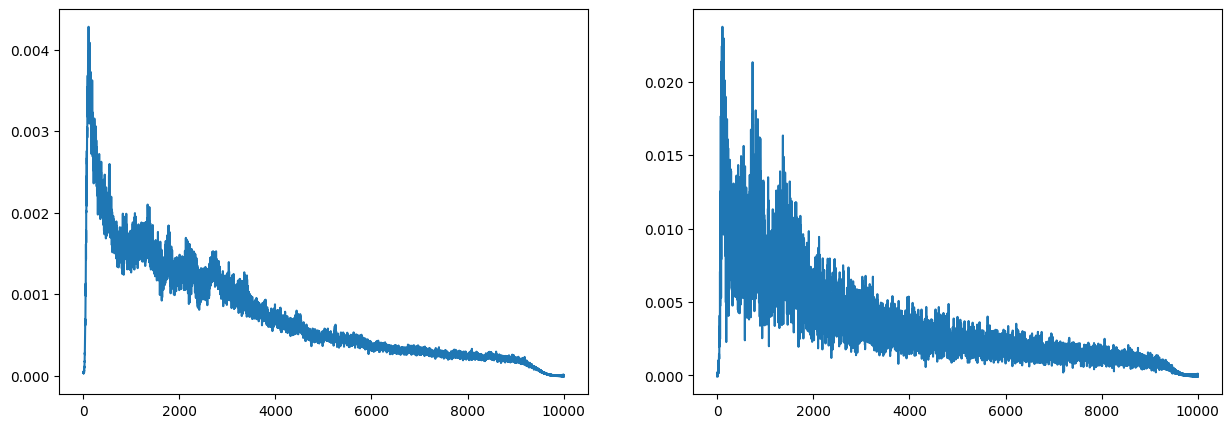

Starting cv 5


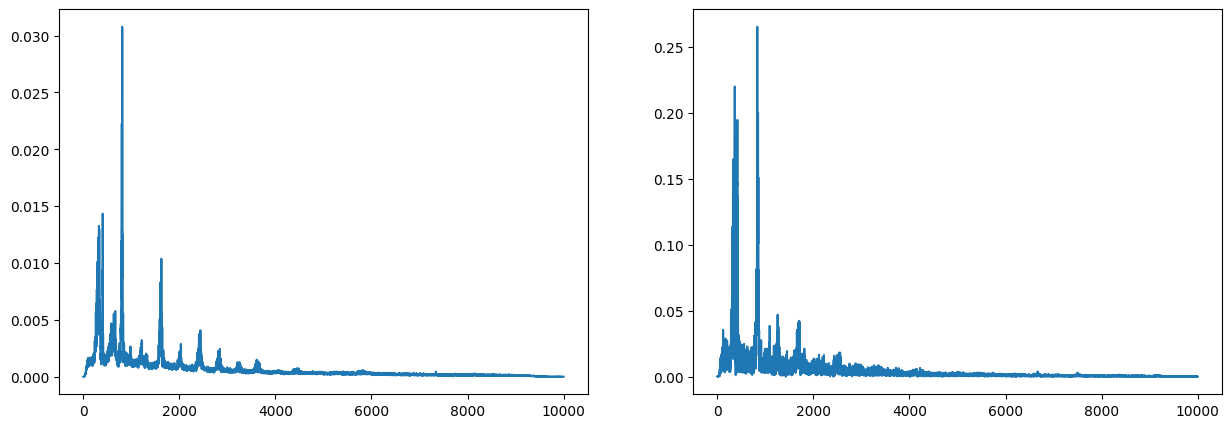

Starting cv 5


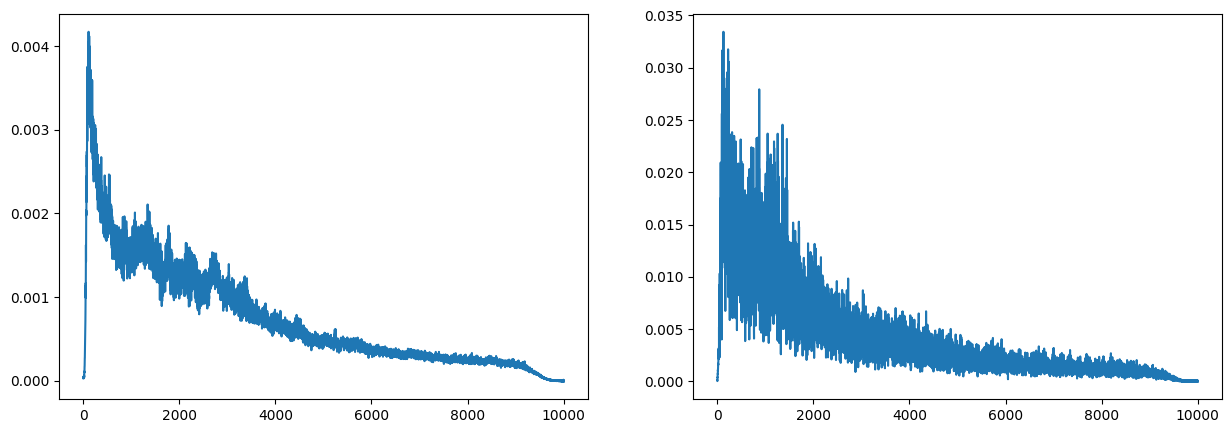

Starting cv 6


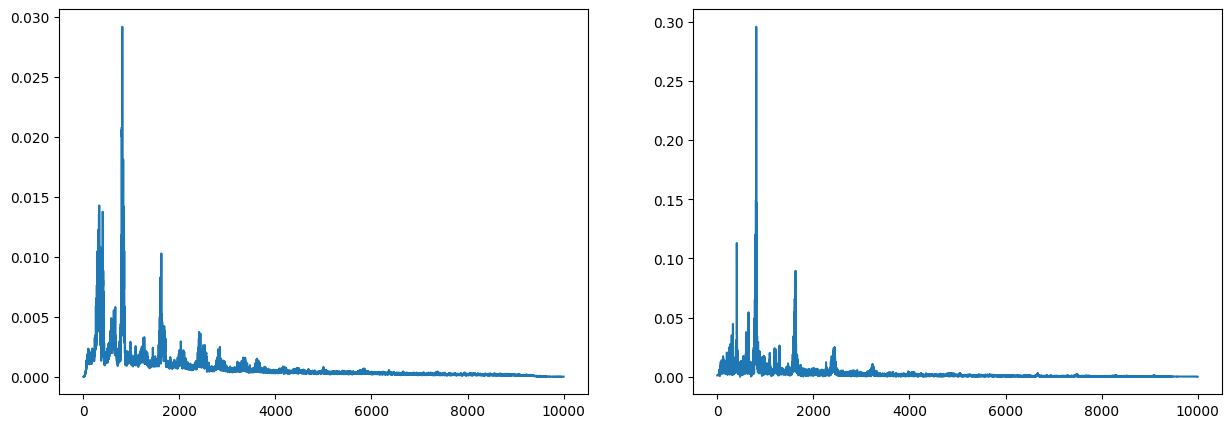

Starting cv 6


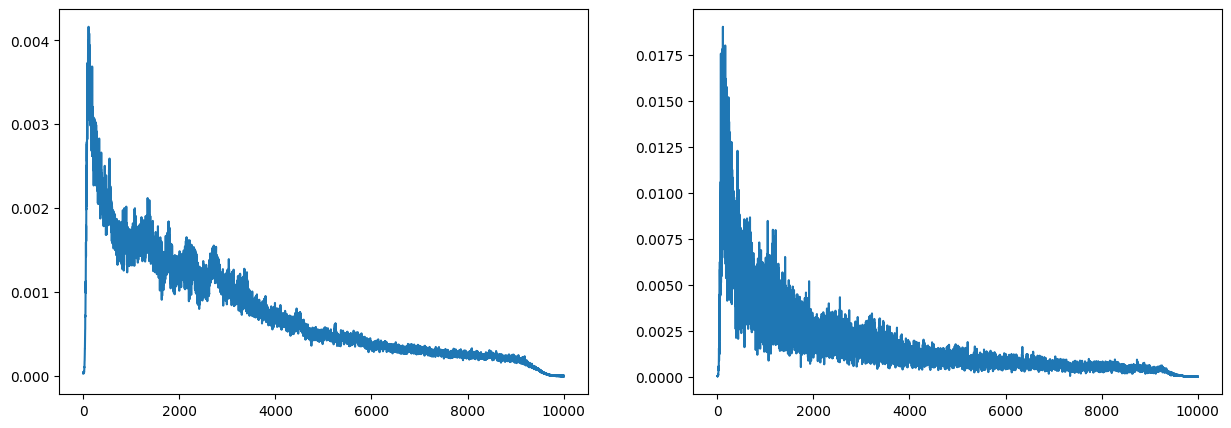

Starting cv 7


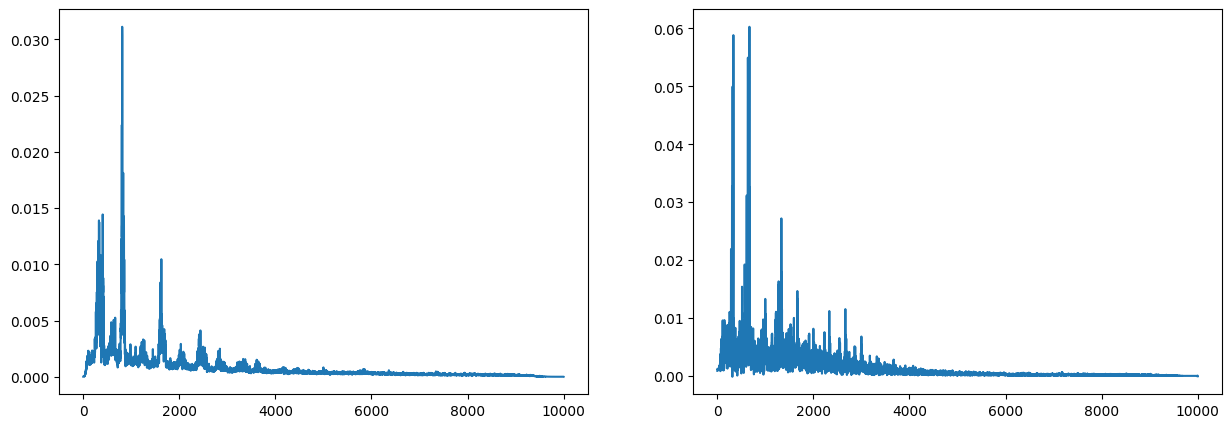

Starting cv 7


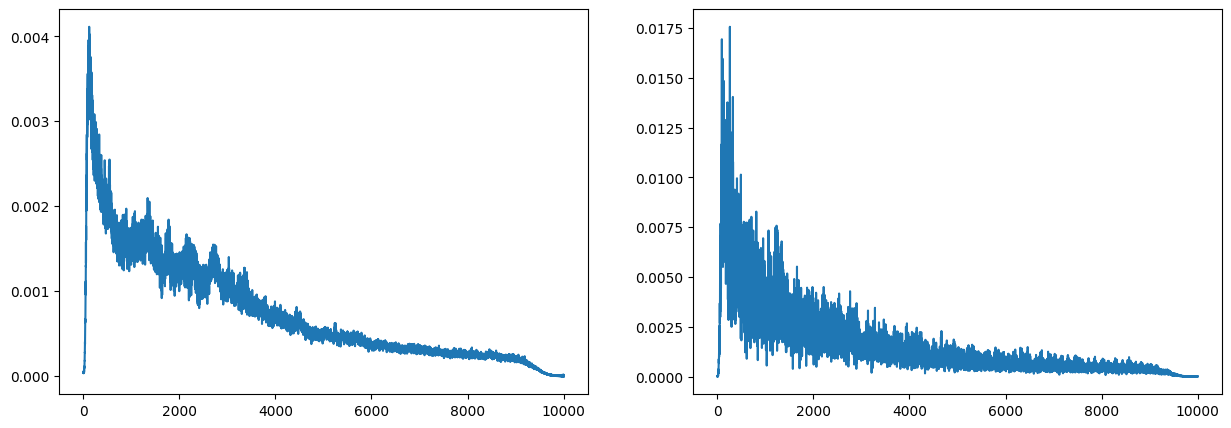

Starting cv 8


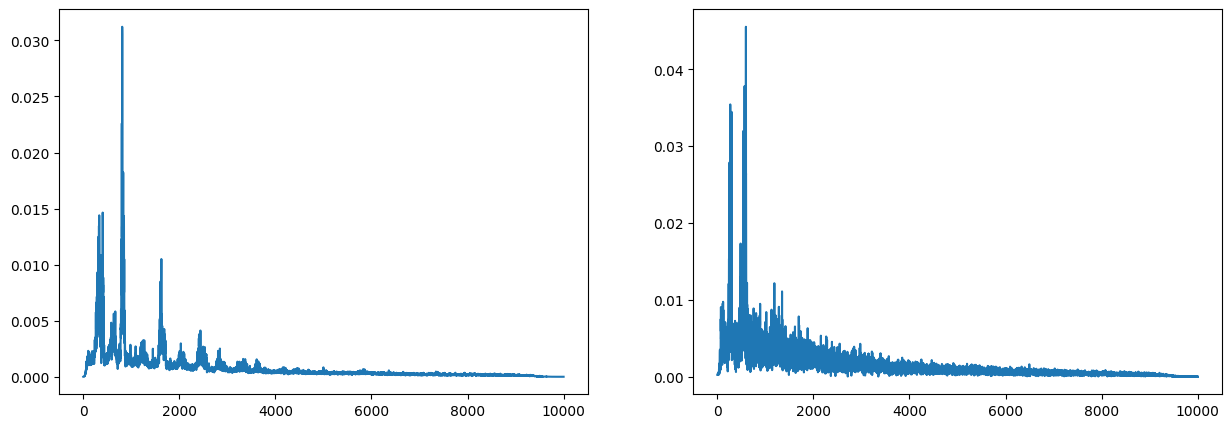

Starting cv 8


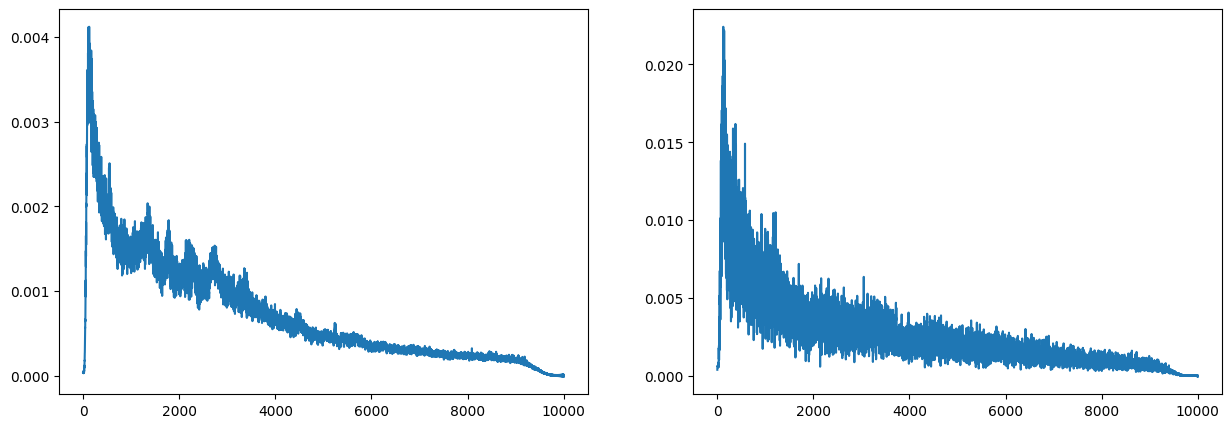

Starting cv 9


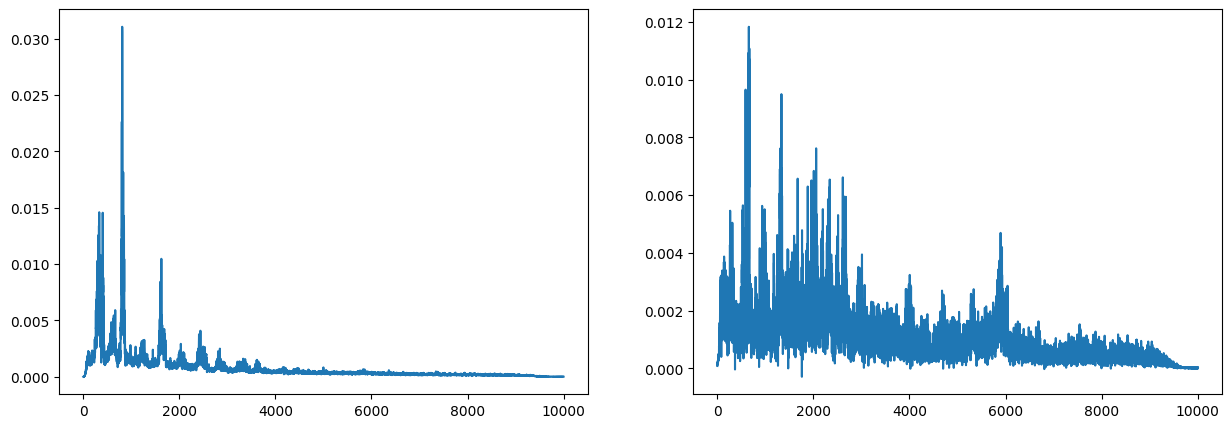

Starting cv 9


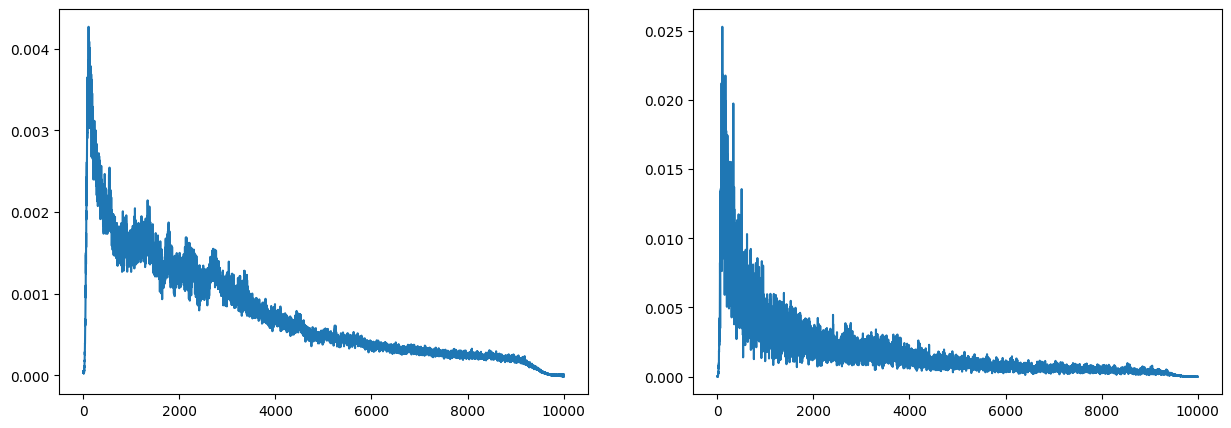

Starting cv 10


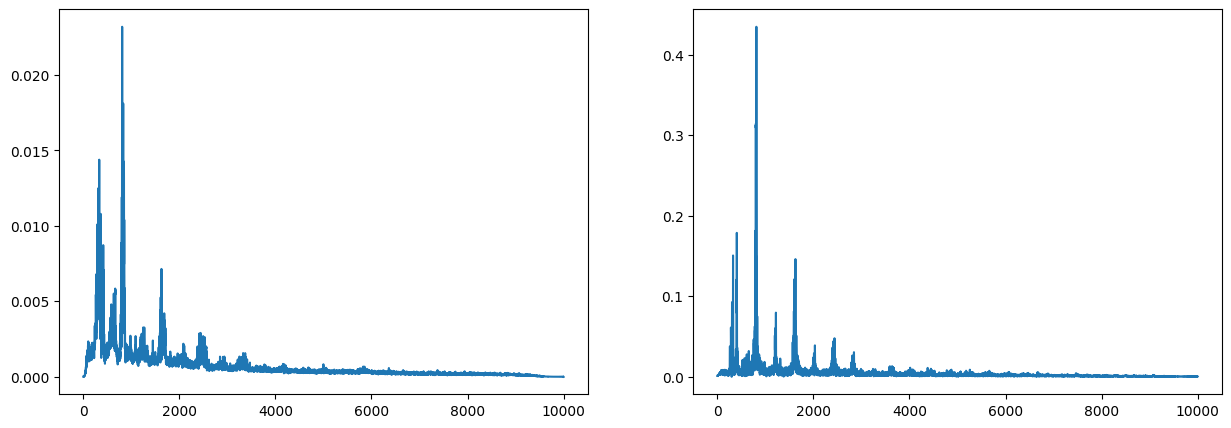

Starting cv 10


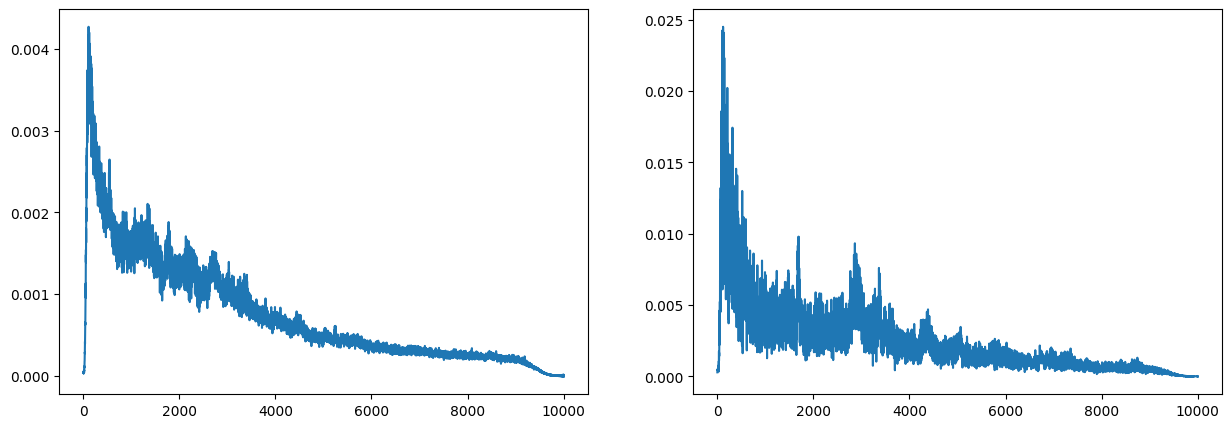

Starting cv 12


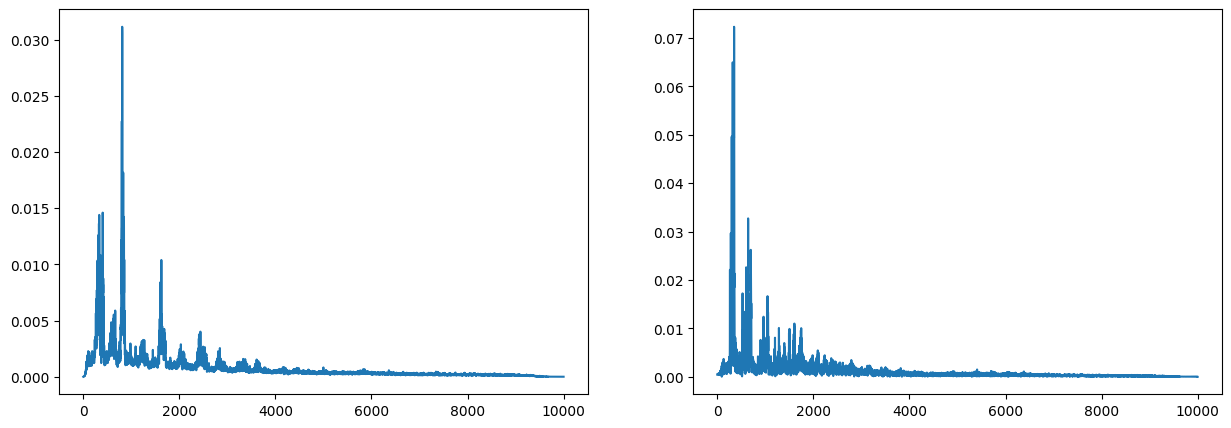

Starting cv 12


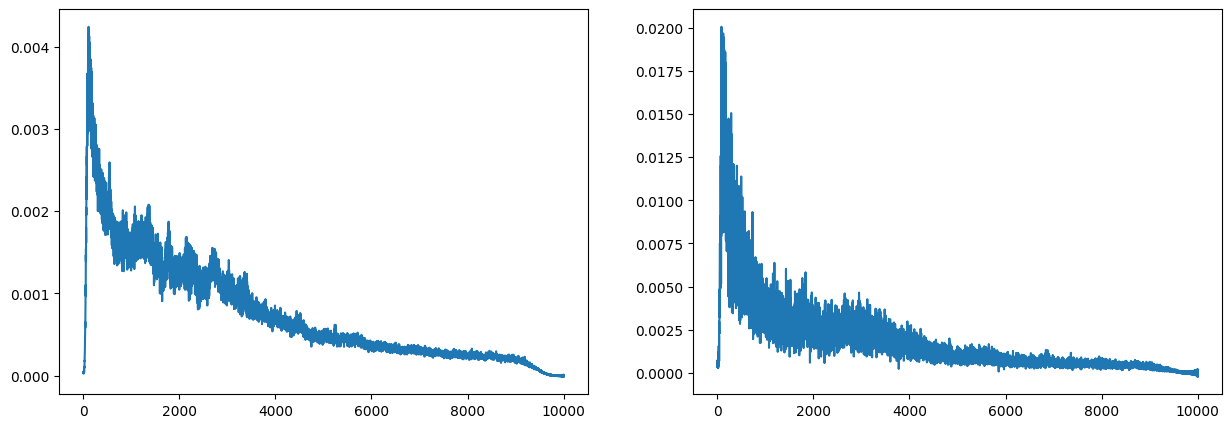

Starting cv 13


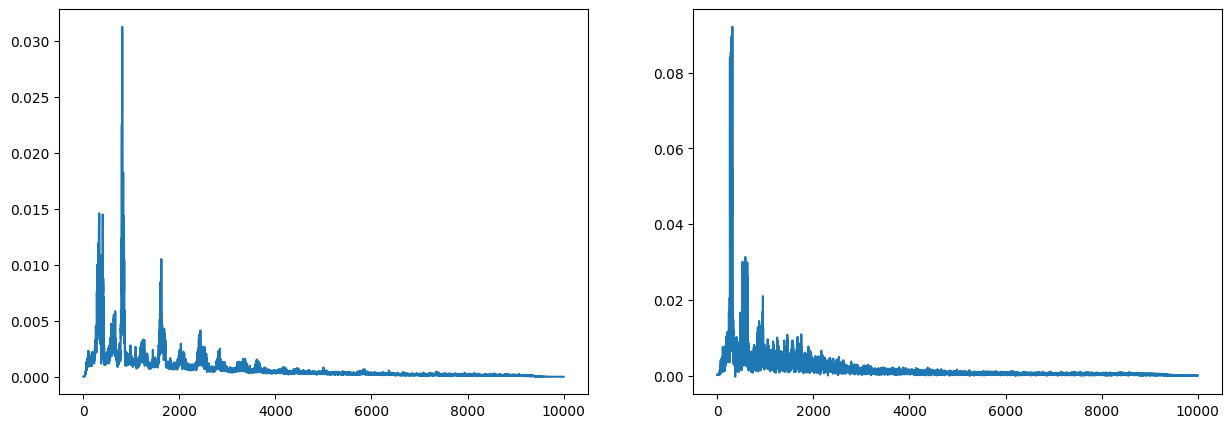

Starting cv 13


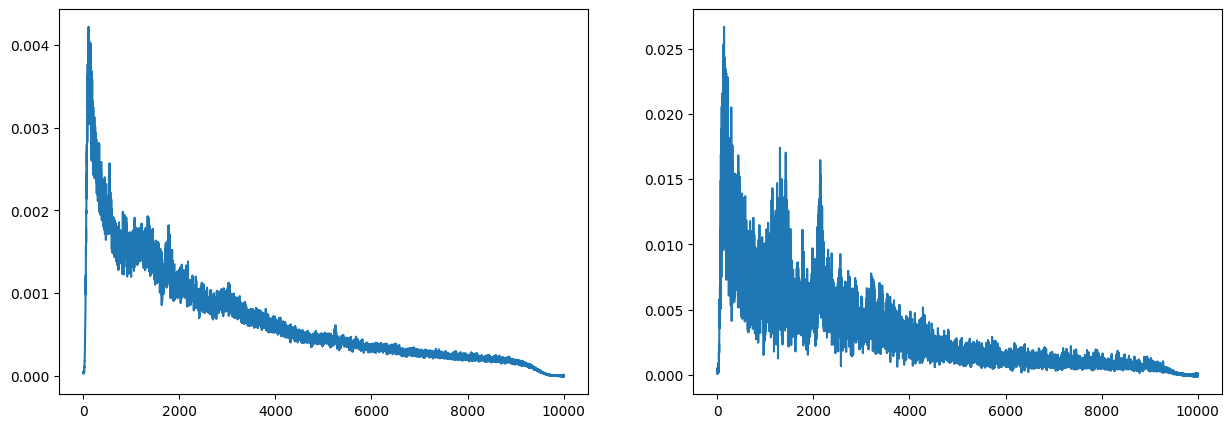

Starting cv 14


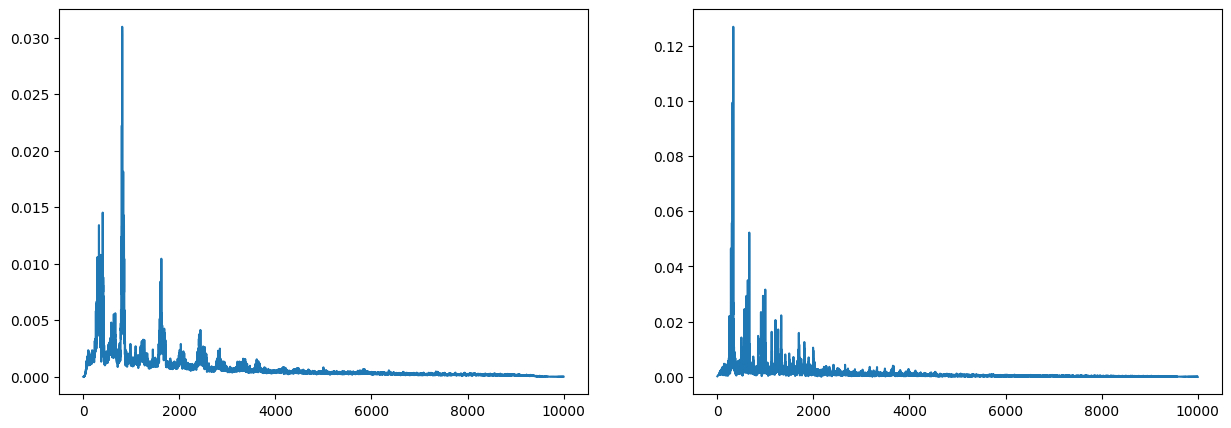

Starting cv 14


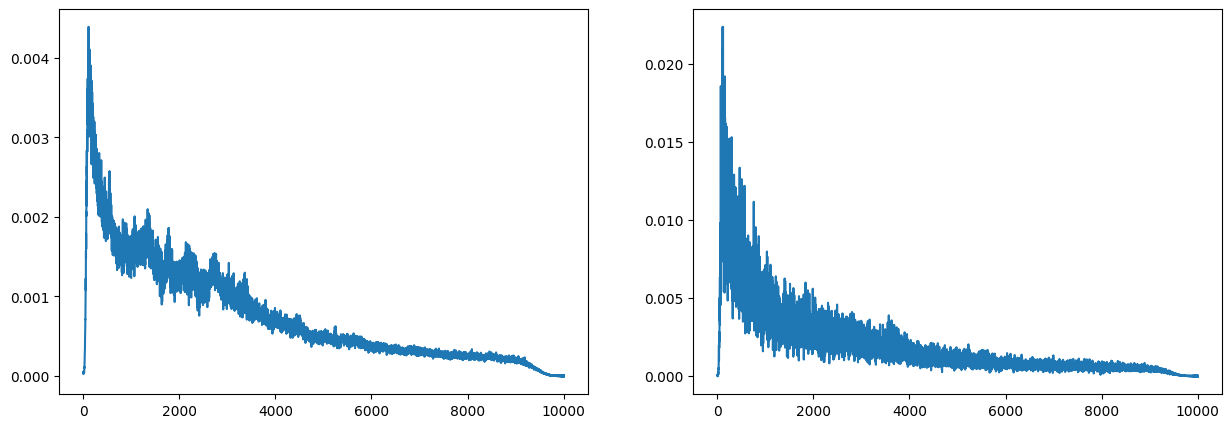

Starting cv 15


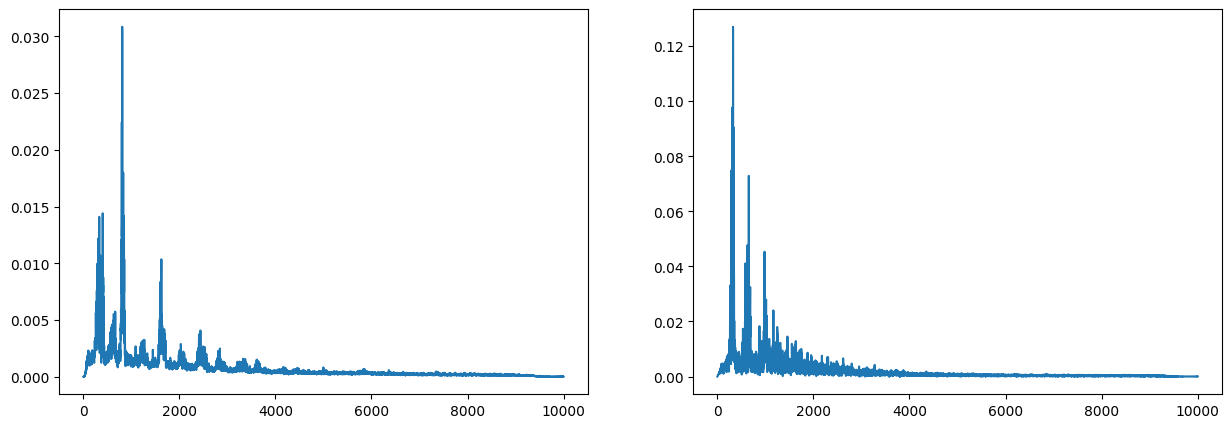

Starting cv 15


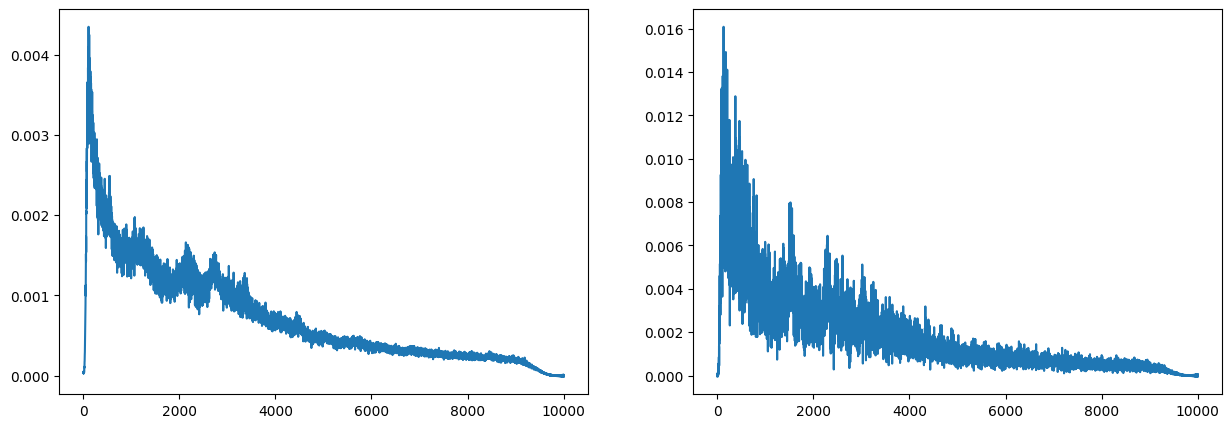

Starting cv 16


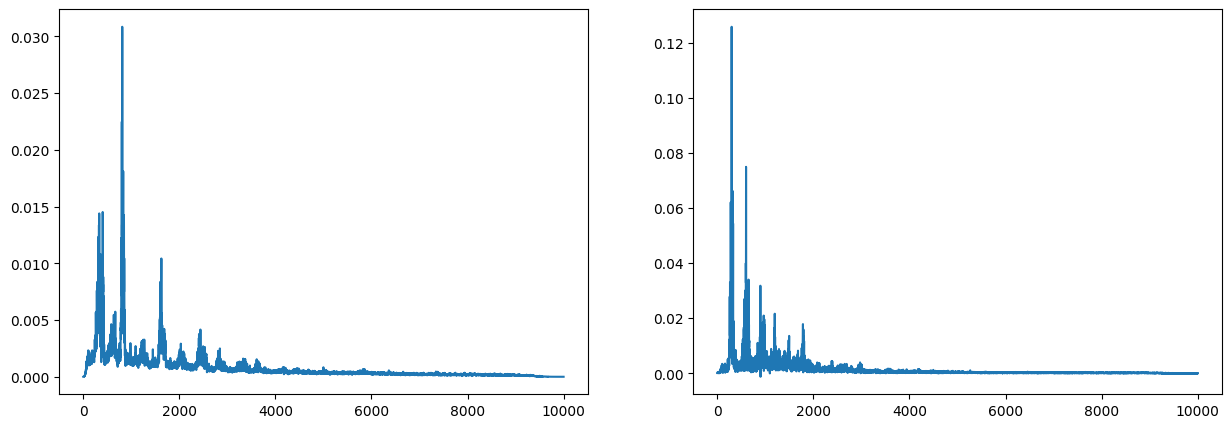

Starting cv 16


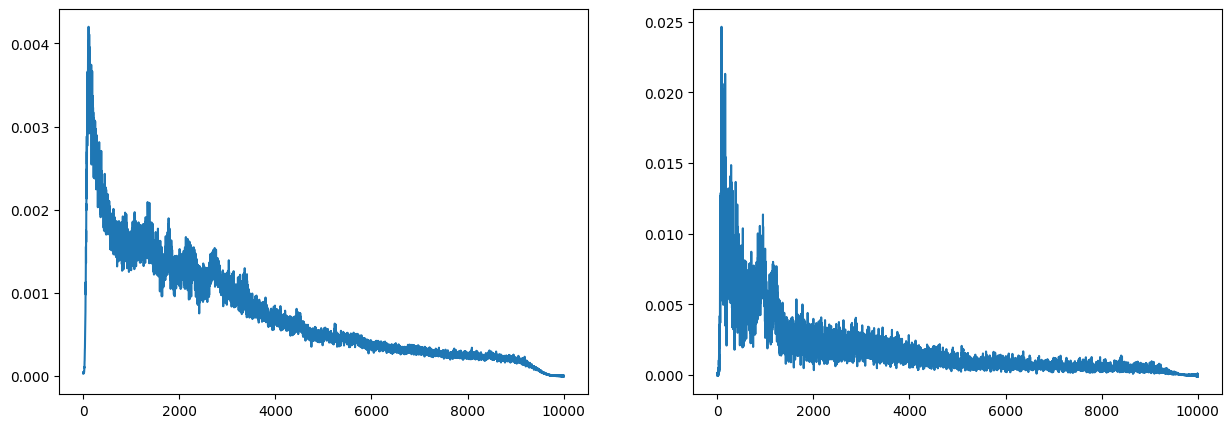

Starting cv 17


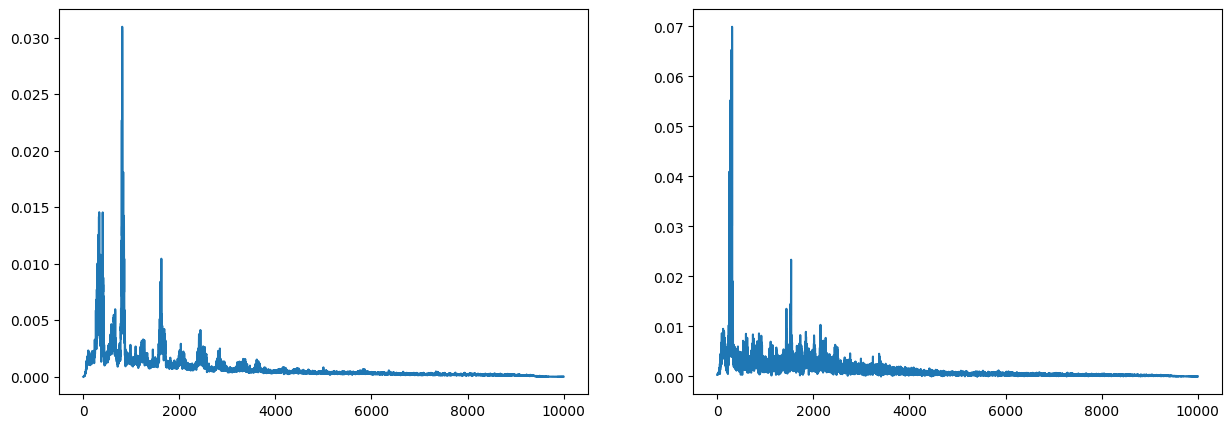

Starting cv 17


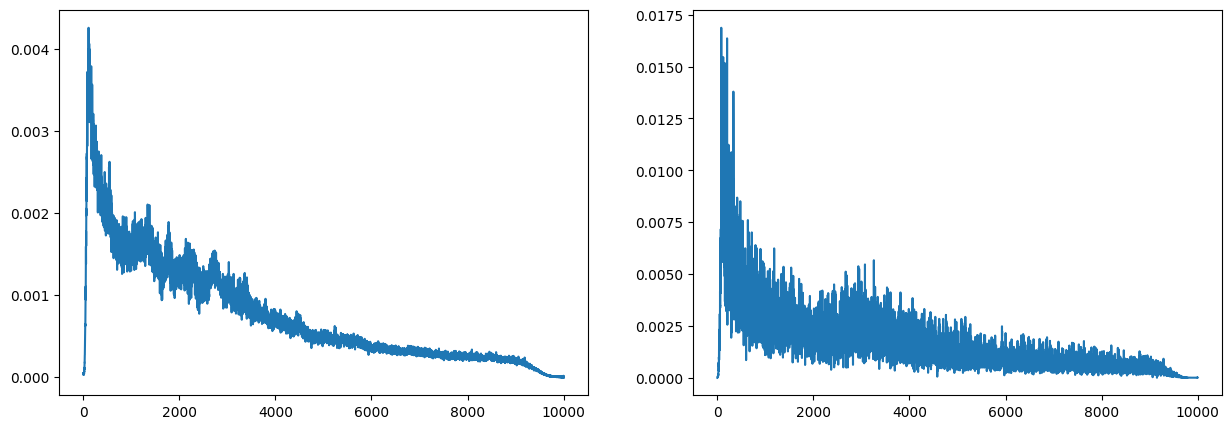

In [70]:
if dataset == 'harvar':
    if device1.find("maxim") != -1:
        data_name = 'harvar_maxim'
    elif device1.find("empatica") != -1:
        data_name = 'harvar_empat'
    elif device1.find("bluesense") != -1:
        data_name = 'harvar_bluesense'

    if device2.find("maxim") != -1:
        test_data_name = 'harvar_maxim'
    elif device2.find("empatica") != -1:
        test_data_name = 'harvar_empat'
    elif device2.find("bluesense") != -1:
        test_data_name = 'harvar_bluesense'

    data_utils = HARVARUtils()
    # harvar
    # iterating through 8 cv
    full_1_x, full_1_y = data_utils.load_all_the_data_harvar(device1, HARVAR_CV, load_only_walking)
    # normalization
    full_1_x = normalization(full_1_x)
    full_2_x, full_2_y = data_utils.load_all_the_data_harvar(device2, HARVAR_CV, load_only_walking)
    # normalization
    full_2_x = normalization(full_2_x)


    if data_name == 'harvar_maxim':
        train_sampling_rate = 25
    if data_name == 'harvar_empat':
        train_sampling_rate = 64
    if data_name == 'harvar_bluesense':
        train_sampling_rate = 100

    if test_data_name == 'harvar_maxim':
        test_sampling_rate = 25
    if test_data_name == 'harvar_empat':
        test_sampling_rate = 64
    if test_data_name == 'harvar_bluesense':
        test_sampling_rate = 100

    participants = HARVAR_CV

else:
    data_utils = REALDISPUtils()
    root_path = os.path.join('..', '..', 'data', 'realdisp')
    # realdisp
    # iterating through 34 cv
    full_1_x, full_1_y = data_utils.load_all_the_data_realdisp(root_path, device1, REALDISP_CV)
    # normalization
    full_1_x = normalization(full_1_x)
    full_2_x, full_2_y = data_utils.load_all_the_data_realdisp(root_path, device2, REALDISP_CV)
    # normalization
    full_2_x = normalization(full_2_x)
    participants = REALDISP_CV

# bandwidth ranges
bandwidth_range = [0.2, 0.5, 0.9, 1.3, 1.5, 1.6]

# create a dataframe to store the mean mmd results on 3 axis
mean_mmd = pd.DataFrame(columns=['CV', 'activity', 'mmd', 'std_div'])

full_1_x = pd.concat([full_1_x, full_1_y], axis=1)
full_2_x = pd.concat([full_2_x, full_2_y], axis=1)

# activities are the unique values in the full_1_y df
activities = full_1_y.unique()

for i in participants:
    for j in activities:
        # filter out the activity in focus
        full_1_x_activity = full_1_x[full_1_x['activity_id'] == j]
        full_2_x_activity = full_2_x[full_2_x['activity_id'] == j]
        print('Starting cv', i)
        train = full_1_x_activity[full_1_x_activity['sub_id'] != i]
        test = full_2_x_activity[full_2_x_activity['sub_id'] == i]



        # drop the activity column
        train = train.drop(columns=['activity_id'])
        test = test.drop(columns=['activity_id'])

        # get only the 'Acc_X', 'Acc_Y', 'Acc_Z' columns as numpy matrix
        train = train.iloc[:, 1:-1].to_numpy()
        test = test.iloc[:, 1:-1].to_numpy()

        if data_name != test_data_name:
            # resample the data
            test = resample_data(test, test_sampling_rate, train_sampling_rate)

        # create a 1x2 subplot
        fig, axs = plt.subplots(1, 2, figsize=(15, 5))
        new_test = bandpass_filter(train[:, 1], 0.5, 60, 64)
        N = len(new_test[2])
        normalize = N/2
        resampled = resample(2*np.abs(rfft(new_test[2]))/N, 10000)
        axs[0].plot(resampled)

        new_test = bandpass_filter(test[:, 1], 0.5, 60, 64)
        N = len(new_test[2])
        normalize = N/2
        resampled = resample(2*np.abs(rfft(new_test[2]))/N, 10000)
        axs[1].plot(resampled)

        plt.show()

